In [1]:
! pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.4 MB/s 


In [7]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import InputXGradient
from captum.attr import IntegratedGradients
from captum.attr import GuidedBackprop
from captum.attr import InputXGradient
from captum.attr import DeepLift
from captum.attr import LRP
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [3]:
batch_size = 64

data_train = torchvision.datasets.MNIST(root = "./data/", transform = transforms.ToTensor(), train = True, download = True)
data_test = torchvision.datasets.MNIST(root="./data/", transform = transforms.ToTensor(), train = False)

data_loader_train = torch.utils.data.DataLoader(data_train, batch_size, shuffle = True)
data_loader_test = torch.utils.data.DataLoader(data_test, batch_size, shuffle = True)

classes = ('0','1','2','3','4','5','6','7','8','9')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.ReLU()

        self.fc = nn.Sequential(
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        x = self.relu1(self.pool1(self.conv1(x)))
        x = self.relu2(self.pool2(self.conv2(x)))
        x = x.view(-1, 400)
        x = self.fc(x)
        return x

net = Net()
summary(net, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
              ReLU-3            [-1, 6, 13, 13]               0
            Conv2d-4           [-1, 16, 11, 11]             880
         MaxPool2d-5             [-1, 16, 5, 5]               0
              ReLU-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [6]:
for epoch in range(5):
    for inputs,labels in data_loader_train:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

total = 0
correct = 0
for inputs, labels in data_loader_test:
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on test images: 98.39 %


In [13]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs)
    
    return tensor_attributions

ind = 1
images, labels = next(iter(data_loader_test))
input = images[ind].unsqueeze(0)
input.requires_grad = True
net.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [14]:
ig = IntegratedGradients(net)
attr_ig = attribute_image_features(ig, input, baselines=input * 0)
attr_ig = np.transpose(attr_ig.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

gbp = GuidedBackprop(net)
attr_gbp = attribute_image_features(gbp, input)
attr_gbp = np.transpose(attr_gbp.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

# ix = InputXGradient(net)
# attr_ix = attribute_image_features(ix, input)
# attr_ix = np.transpose(attr_ix.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

lrp = LRP(net)
attr_lrp = attribute_image_features(lrp, input)
attr_lrp = np.transpose(attr_lrp.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/usr/local/lib/python3.7/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:65: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."
/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Original Image
Predicted: 4  Probability: 0.9998072981834412


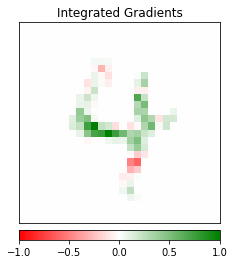

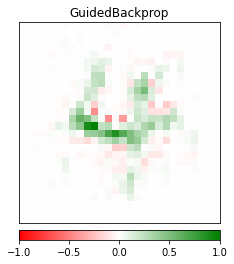

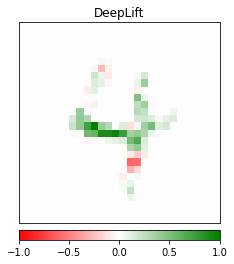

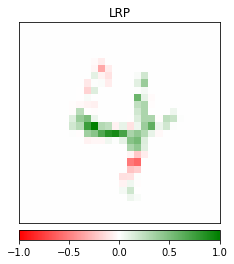

In [15]:
print('Original Image')
print('Predicted:', classes[torch.argmax(net(input), 1)], 
      ' Probability:', torch.max(F.softmax(net(input), 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(attr_ig, original_image, method="heat_map",sign="all",
                          show_colorbar=True, title="Integrated Gradients", fig_size=(4,4))

_ = viz.visualize_image_attr(attr_gbp, original_image, method="heat_map", sign="all",
                          show_colorbar=True, title="GuidedBackprop", fig_size=(4,4))

_ = viz.visualize_image_attr(attr_dl, original_image, method="heat_map",sign="all",show_colorbar=True, 
                          title="DeepLift", fig_size=(4,4))

_ = viz.visualize_image_attr(attr_lrp, original_image, method="heat_map", sign="all",
                          show_colorbar=True, title="LRP", fig_size=(4,4))

In [20]:
from scipy.stats import spearmanr

def helper(algorithm, input, target, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=target,
                                              **kwargs)
    
    return tensor_attributions.detach().numpy().squeeze()

data_loader_spearmanr = torch.utils.data.DataLoader(data_test, 1, shuffle=True)
coefficients = [[0]*4 for i in range(4)]
net.eval()
for images, labels in data_loader_spearmanr:
    input = images

    ig = IntegratedGradients(net)
    attr_ig = helper(ig, input, labels, baselines=input * 0)

    gbp = GuidedBackprop(net)
    attr_gbp = helper(gbp, input, labels)

    # ix = InputXGradient(net)
    # attr_ix = helper(ix, input, labels)

    dl = DeepLift(net)
    attr_dl = helper(dl, input, labels, baselines=input*0)

    lrp = LRP(net)
    attr_lrp = helper(lrp, input, labels)


    src = [attr_ig, attr_gbp, attr_dl, attr_lrp]
    for i in range(4):
        for j in range(4):
            coefficients[i][j] += spearmanr(src[i].flatten(), src[j].flatten())[0]

coefficients = np.array(coefficients)/10000

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.7/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:65: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."
/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.

In [21]:
coefficients

array([[1.        , 0.30601559, 0.8192044 , 0.78607452],
       [0.30601559, 1.        , 0.33186295, 0.28773924],
       [0.8192044 , 0.33186295, 1.        , 0.7901909 ],
       [0.78607452, 0.28773924, 0.7901909 , 1.        ]])